In [1]:
import numpy as np
import matplotlib.pyplot as plt


class MyDNN:

    def __init__(self, Q, etall=.5, ETA=None):
        if len(Q) < 3:
            raise ValueError
        self.Q = Q
        self.m = len(Q) - 2

        if ETA is None:
            self.ETA = [etall,] * (self.m+1)
        elif len(ETA) != self.m+1:
            raise ValueError
        else:
            self.ETA = ETA

        self.W = [0,]
        self.THETA = [0,]
        for c in range(1, self.m+2):
            self.W.append(np.random.rand(Q[c-1], Q[c]))
            self.THETA.append(np.random.rand(Q[c]))

        self.errs = list()

    def __f(self, X):
        return 1 / (1 + np.exp(-X))

    def estimate(self, X):
        B = np.asarray(X)
        for c in range(1, self.m+2):
            B = self.__f(np.matmul(B, self.W[c]) - self.THETA[c])
        return B

    def ek(self, X, Y):
        YB = self.estimate(X)
        YYB = YB - np.asarray(Y)
        err = np.matmul(YYB, YYB) / 2.0
        return err

    def bp(self, X, Y):
        B = [0,] * (self.m+2)
        Z = [0,] * (self.m+2)
        G = [0,] * (self.m+2)
        ETA = [0,] + list(self.ETA)

        B[0] = np.asarray(X)

        for c in range(1, self.m+2):
            B[c] = self.__f(np.matmul(B[c-1], self.W[c]) - self.THETA[c])

        YB = B[self.m+1]
        YYB = YB - np.asarray(Y)
        err = np.matmul(YYB, YYB) / 2.0
        self.errs.append(err)

        Z[self.m+1] = YYB

        for c in range(self.m+1, 0, -1):
            G[c] = Z[c] * B[c] * (B[c] - 1)
            Z[c-1] = -np.matmul(self.W[c], G[c])
            GC = ETA[c] * G[c]
            self.THETA[c] -= GC
            self.W[c] += np.outer(B[c-1], GC)

    def draw(self, title='Ek', label='Ek', savefig=None, rate=None):

        lerrs = len(self.errs)
        plt.plot(range(lerrs), self.errs, label=label)

        if rate is not None:
            lrate = len(rate)
            rate2 = np.asarray(rate)
            nn = np.max(self.errs) // np.max(rate2)
            if nn > 1:
                plt.plot(np.arange(0, lerrs, lerrs/lrate),
                         rate2 * nn, label='rate*%d' % nn)
            else:
                plt.plot(np.arange(0, lerrs, lerrs/lrate),
                         rate, label='rate')

        plt.title(title + str(self.Q).replace(' ', ''))
        plt.legend()
        plt.grid()
        if savefig is None:
            plt.show()
        else:
            plt.savefig('./'+str(savefig)+'.png')
        plt.clf()


In [84]:
def test_argmax(d=8):
    n_epochs = 4
    n_samples = 1024
    n1 = 256
    dnn = MyDNN([d, d, d])

    def get_in(x):
        X = np.random.random_sample(d) / 1000.0
        X[(x+1) % d] += 1 - np.sum(X)
        return X

    def test():
        vv = 0
        for i in np.random.randint(d, size=n1):
            if np.argmax(dnn.estimate(get_in(i))) == i:
                vv += 1
        return vv / n1

    rate = list()
    flg = 0
    while flg < n_epochs:
        for i, x in enumerate(np.random.randint(d, size=n_samples)):
            X = get_in(x)
            Y = np.zeros(d)
            Y[x % d] = 1
            dnn.bp(X, Y)
            rate.append(test())
        flg += 1

    dnn.draw(title='argmax-good', rate=rate)


In [85]:
def test_argmax_bad(d=8):
    n_epochs = 2
    n_samples = 1024
    n1 = 256
    dnn = MyDNN([d, d, d])

    def get_in():
        X = np.random.random_sample(d)
        X /= np.sum(X)
        return X

    def get_out(X):
        Y = np.zeros(d)
        Y[np.argmax(X)] = 1
        return Y

    def test():
        vv = 0
        for _ in range(n1):
            X = get_in()
            if np.argmax(dnn.estimate(get_in())) == np.argmax(X):
                vv += 1
        return vv / n1

    rate = list()
    flg = 0
    while flg < n_epochs:
        for _ in range(n_samples):
            X = get_in()
            Y = get_out(X)
            dnn.bp(X, Y)
            rate.append(test())
        flg += 1

    dnn.draw(title='argmax-bad', rate=rate)


In [86]:
def test_sum(l=8):
    n_samples = 256
    dnn = MyDNN([l*8, 16, l])
    for x in range(n_samples):
        X = np.random.random_sample(l*8)
        X /= np.sum(X)
        Y = np.asarray([np.sum(X[i*8:(i+1)*8]) for i in range(l)])
        dnn.bp(X, Y)

    dnn.draw(title='sum')


In [87]:
def test_equal(d=8):
    n_samples = 256
    dnn = MyDNN([d, 8, d])
    for x in range(n_samples):
        X = np.random.random_sample(d)
        X /= np.sum(X)
        dnn.bp(X, X)

    dnn.draw(title='equal')


In [21]:
def test_linear(d=8):
    n_samples = 1024
    M = np.random.random_sample((d, d))
    dnn = MyDNN([d, 1, d])
    for _ in range(n_samples):
        X = np.random.random_sample(d)
        X /= np.sum(X)
        Y = np.matmul(X, M)
        Y /= np.sum(Y)
        dnn.bp(X, Y)

    dnn.draw(title='linear')


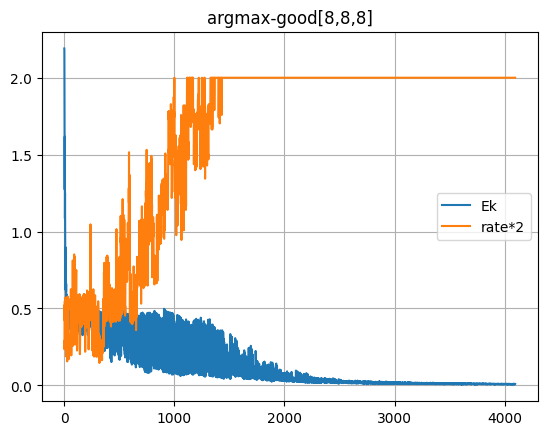

<Figure size 640x480 with 0 Axes>

In [89]:
test_argmax()


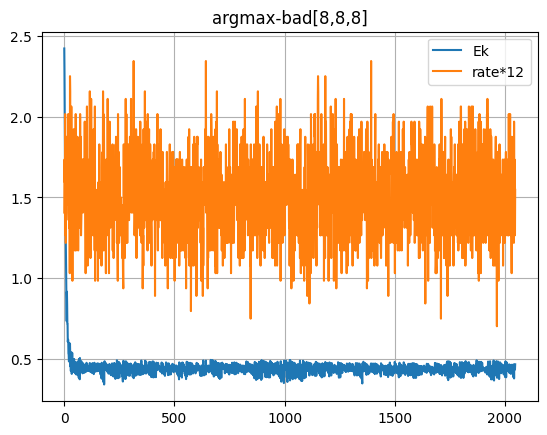

<Figure size 640x480 with 0 Axes>

In [90]:
test_argmax_bad()


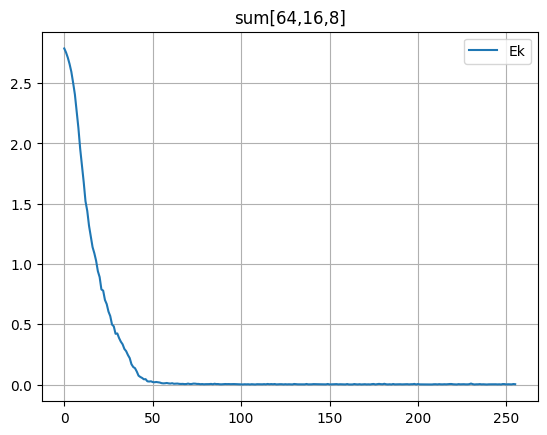

<Figure size 640x480 with 0 Axes>

In [91]:
test_sum()


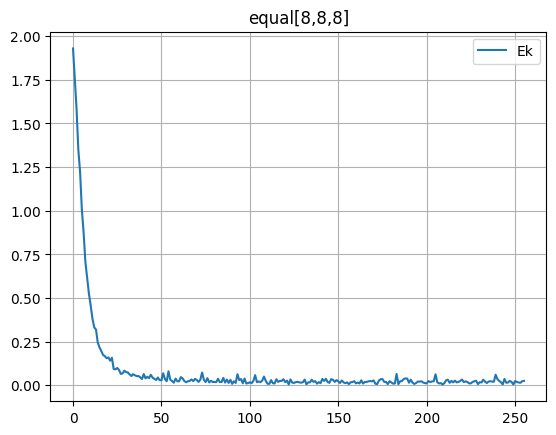

<Figure size 640x480 with 0 Axes>

In [92]:
test_equal()


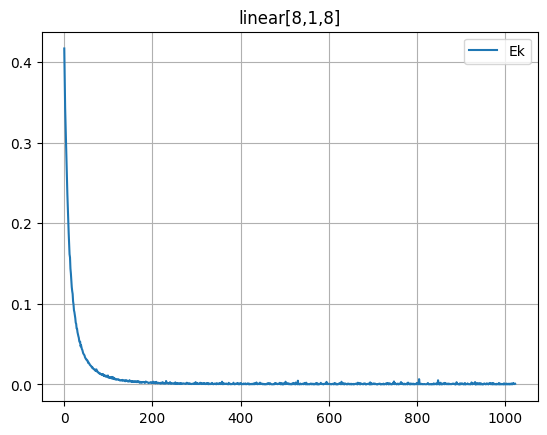

<Figure size 640x480 with 0 Axes>

In [22]:
test_linear()
